# Rendu TSA 

Mathieu Laversin 
Alexandra Mille egea
Ryan Pegoud

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('fr.csv')
df.head()

,start,end,load
0,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+00:00,70929.0
1,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+00:00,69773.0
2,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+00:00,66417.0
3,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00,64182.0
4,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00,63859.0


# **Descriptive analysis**

In [ ]:
df.describe()

,load
count,48870.000000
mean,53556.308267
std,11682.584881
min,29398.000000
25%,44616.000000
50%,51932.000000
75%,61629.750000
max,158000.000000


# **Down sampling**

In [ ]:
df['start'] = pd.to_datetime(df['start'], format='%Y/%m/%d %H:%M:%S')
df['end'] = pd.to_datetime(df['end'], format='%Y/%m/%d %H:%M:%S')

df.set_index('start', inplace=True)

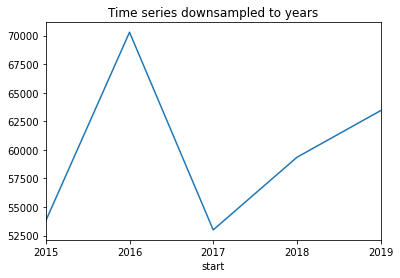

In [ ]:
df["load"].asfreq('Y').plot()
plt.title('Time series downsampled to years')
plt.show()

In [ ]:
df['year'] = pd.DatetimeIndex(df.index).year
yearly = df.groupby('year').agg('sum')
yearly

,load
year,
2015,470012917.0
2016,477474024.0
2017,475934939.0
2018,470394794.0
2019,467000414.0
2020,256479697.0


# **Monthly Moving Averages**

In [ ]:
df['month'] = pd.DatetimeIndex(df.index).month
df_month_year= df.groupby(['year','month']).agg('mean')
df_month_year

load
year month              
2015 1      69523.116935
     2      71374.474702
     3      60624.438172
     4      50608.841667
     5      45209.040377
...                  ...
2020 3      55252.318489
     4      42409.579167
     5      40946.911290
     6      42225.624478
     7      44123.798387

[67 rows x 1 columns]

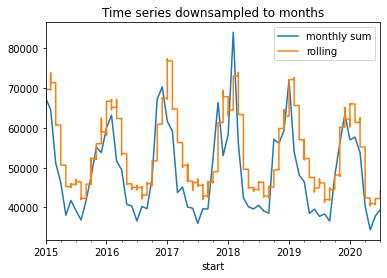

In [ ]:
df["load"].asfreq('M').plot(label='monthly sum')

rolling_load = df.load.rolling('30D').mean()
rolling_load.plot(label='rolling')
plt.legend()
plt.title('Time series downsampled to months')
plt.show()

# **Seasonality**

In [ ]:
melted_y_m = df.melt(id_vars=['year','month'], value_vars='load').drop('variable',axis=1)
melted_means = melted_y_m.groupby(['year','month']).agg('mean')
melted_means

value
year month              
2015 1      69523.116935
     2      71374.474702
     3      60624.438172
     4      50608.841667
     5      45209.040377
...                  ...
2020 3      55252.318489
     4      42409.579167
     5      40946.911290
     6      42225.624478
     7      44123.798387

[67 rows x 1 columns]

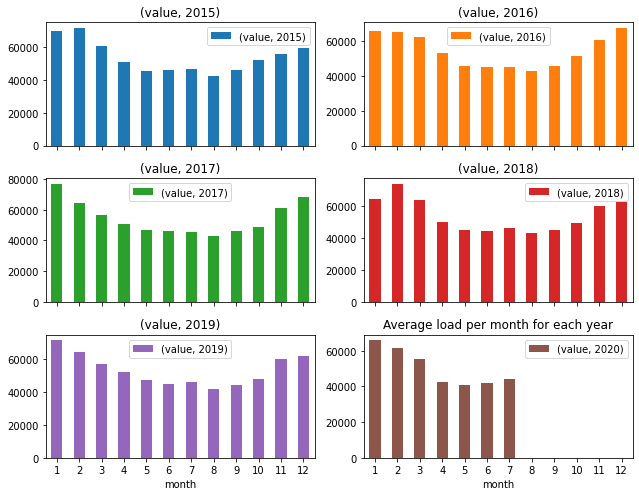

In [ ]:
melted_means.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(3,2))
plt.title('Average load per month for each year')
plt.tight_layout()

In [ ]:
melted_means['year'] = [melted_means.index[i][0] for i in range(melted_means.shape[0])]

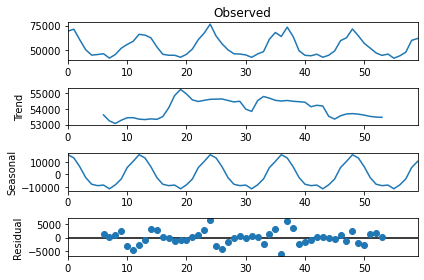

In [ ]:
import statsmodels.api as sm

values = melted_means[melted_means['year']<2020]['value'] # monthly means between 2015 and 2019 (2020 is incomplete)
values = np.array(values, dtype=object)
decomposed = sm.tsa.seasonal_decompose(values, period=12) # yearly seasonality
decomposed.plot()
plt.show()

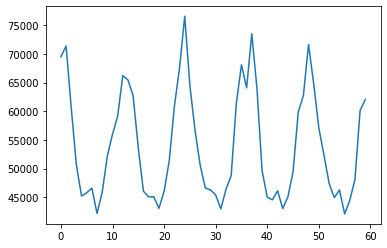

In [ ]:
plt.plot(values)

In [ ]:
train = melted_means[melted_means['year']<2018]
test = melted_means[melted_means['year'].between(2018,2020)]

In [19]:
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# model = ExponentialSmoothing(values, trend='add')
# model_fit = model.fit()
# yhat = model_fit.predict(...)